In [2]:
"""
Laboratorio: Técnicas de Bandits en Ms. Pac-Man
Implementación de 4 técnicas de exploración vs explotación:
1. ε-greedy
2. Valores iniciales optimistas
3. UCB (Upper Confidence Bound)
4. Algoritmos de Gradiente

Basado en el cuadernillo 02_bandits.ipynb
"""

# Instalar dependencias necesarias
!pip install gymnasium[atari]
!pip install ale-py
!pip install autorom
!autorom --accept-license

/bin/bash: line 1: autorom: command not found


In [3]:
import ale_py
print(ale_py.__version__)

0.11.1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
from collections import defaultdict

# Configuración inicial
np.random.seed(42)

In [5]:
class MsPacManBandits:
    def __init__(self):
        """
        Inicializa el entorno de Ms. Pac-Man para bandits.
        Simplificamos las acciones a las 4 direcciones principales.
        """
        self.env = gym.make('ALE/MsPacman-v5', render_mode=None)

        # Simplificamos a 4 acciones principales (como en el Whac-A-Mole original)
        # 0: No-op, 1: Up, 2: Right, 3: Down, 4: Left
        self.actions = [0, 1, 2, 3, 4]  # 5 acciones como en el ejemplo original
        self.n_actions = len(self.actions)

        print(f"Entorno Ms. Pac-Man inicializado con {self.n_actions} acciones")
        print(f"Acciones disponibles: {self.actions}")

    def get_reward(self, action):
        """
        Ejecuta una acción y devuelve la recompensa.
        Normaliza la recompensa para que sea comparable con el ejemplo original.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Normalizar recompensa (Ms. Pac-Man da recompensas grandes)
        # La dividimos por 10 para tener valores más manejables como en el ejemplo
        normalized_reward = reward / 10.0

        # Si el juego termina, reiniciamos
        if terminated or truncated:
            self.env.reset()

        return normalized_reward

    def reset(self):
        """Reinicia el entorno"""
        return self.env.reset()

    def close(self):
        """Cierra el entorno"""
        self.env.close()

In [6]:
def softmax(x):
    """Función softmax para algoritmos de gradiente"""
    exp_x = np.exp(x - np.max(x))  # Estabilidad numérica
    return exp_x / np.sum(exp_x)

In [7]:
def run_epsilon_greedy_experiment(env, partidas=500, turnos=200, epsilons=[0, 0.01, 0.1]):
    """
    Técnica 1: ε-greedy
    Implementación exacta del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento ε-greedy ===")

    recompensas_medias = np.zeros((len(epsilons), turnos))
    acciones_optimas = np.zeros((len(epsilons), turnos))

    # Estimamos la mejor acción empíricamente
    print("Estimando mejor acción...")
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):  # Muestreo para estimar
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]
    print(f"Mejor acción estimada: {mejor_accion}")

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, e in enumerate(epsilons):
            env.reset()
            Q = {k: 0 for k in env.actions}
            acciones_count = {k: 0 for k in env.actions}
            recompensas_sum = {k: 0 for k in env.actions}

            for exp in range(turnos):
                # Elegir acción según ε-greedy
                if np.random.uniform(0, 1) < e:
                    # Acción aleatoria (exploración)
                    a = np.random.choice(env.actions)
                else:
                    # Acción con mayor valor (explotación)
                    maxQ = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        if Q[action] > maxQ:
                            maxQ = Q[action]
                            a = action

                # Ejecutar acción y obtener recompensa
                recompensa = env.get_reward(a)

                # Actualizar estadísticas
                acciones_count[a] += 1
                recompensas_sum[a] += recompensa
                Q[a] = recompensas_sum[a] / acciones_count[a]

                # Guardar métricas
                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, epsilons

In [8]:
def run_optimistic_initialization_experiment(env, partidas=500, turnos=200):
    """
    Técnica 2: Valores iniciales optimistas
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento Valores Optimistas ===")

    epsilons = [0, 0.1]  # Greedy optimista vs ε-greedy normal
    alpha = 0.5
    recompensas_medias = np.zeros((len(epsilons), turnos))
    acciones_optimas = np.zeros((len(epsilons), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, e in enumerate(epsilons):
            env.reset()
            Q = {k: 0 for k in env.actions}

            # Inicialización optimista para agente greedy
            if e == 0:
                Q = {k: 10 for k in env.actions}  # Valores altos optimistas

            for exp in range(turnos):
                # Elegir acción
                if np.random.uniform(0, 1) < e:
                    a = np.random.choice(env.actions)
                else:
                    maxQ = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        if Q[action] > maxQ:
                            maxQ = Q[action]
                            a = action

                # Ejecutar y actualizar (implementación incremental)
                recompensa = env.get_reward(a)
                Q[a] += alpha * (recompensa - Q[a])

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, epsilons

In [9]:
def run_ucb_experiment(env, partidas=500, turnos=200, c=1):
    """
    Técnica 3: UCB (Upper Confidence Bound)
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento UCB ===")

    alpha = 0.5
    methods = ['UCB', 'ε-greedy']
    epsilon = 0.1
    recompensas_medias = np.zeros((len(methods), turnos))
    acciones_optimas = np.zeros((len(methods), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, method in enumerate(methods):
            env.reset()
            Q = {k: 0 for k in env.actions}
            acciones_count = {k: 1 for k in env.actions}  # Inicializar en 1 para UCB

            for exp in range(turnos):
                if method == 'UCB':
                    # Selección UCB
                    maxA = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        ucb_value = Q[action] + c * math.sqrt(math.log(exp + 1) / acciones_count[action])
                        if ucb_value > maxA:
                            maxA = ucb_value
                            a = action
                else:
                    # ε-greedy para comparación
                    if np.random.uniform(0, 1) < epsilon:
                        a = np.random.choice(env.actions)
                    else:
                        maxQ = -1000
                        a = env.actions[0]
                        for action in env.actions:
                            if Q[action] > maxQ:
                                maxQ = Q[action]
                                a = action

                # Ejecutar y actualizar
                acciones_count[a] += 1
                recompensa = env.get_reward(a)
                Q[a] += alpha * (recompensa - Q[a])

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, methods

In [10]:
def run_gradient_bandit_experiment(env, partidas=500, turnos=200, alphas=[0.1, 0.4]):
    """
    Técnica 4: Algoritmos de Gradiente
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento Algoritmos de Gradiente ===")

    recompensas_medias = np.zeros((len(alphas), turnos))
    acciones_optimas = np.zeros((len(alphas), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, alpha in enumerate(alphas):
            env.reset()
            H = np.zeros(env.n_actions)  # Preferencias iniciales
            pi = softmax(H)  # Probabilidades iniciales
            recompensas = []

            for exp in range(turnos):
                # Elegir acción según probabilidades
                action_idx = np.random.choice(env.n_actions, p=pi)
                a = env.actions[action_idx]

                # Ejecutar acción
                recompensa = env.get_reward(a)
                recompensas.append(recompensa)
                recompensa_media = np.mean(recompensas)

                # Actualizar preferencias (algoritmo de gradiente)
                for j in range(env.n_actions):
                    if j == action_idx:
                        H[j] += alpha * (recompensa - recompensa_media) * (1 - pi[j])
                    else:
                        H[j] -= alpha * (recompensa - recompensa_media) * pi[j]

                # Actualizar probabilidades
                pi = softmax(H)

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, alphas

In [11]:
# Inicializar entorno
print("Iniciando laboratorio de Bandits en Ms. Pac-Man")
print("=" * 50)

env = MsPacManBandits()

Iniciando laboratorio de Bandits en Ms. Pac-Man
Entorno Ms. Pac-Man inicializado con 5 acciones
Acciones disponibles: [0, 1, 2, 3, 4]


In [12]:
# Experimento 1: ε-greedy
print("\n1. TÉCNICA ε-GREEDY")
rewards_eps, optimal_eps, epsilons = run_epsilon_greedy_experiment(env)


1. TÉCNICA ε-GREEDY
=== Ejecutando experimento ε-greedy ===
Estimando mejor acción...
Mejor acción estimada: 0
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


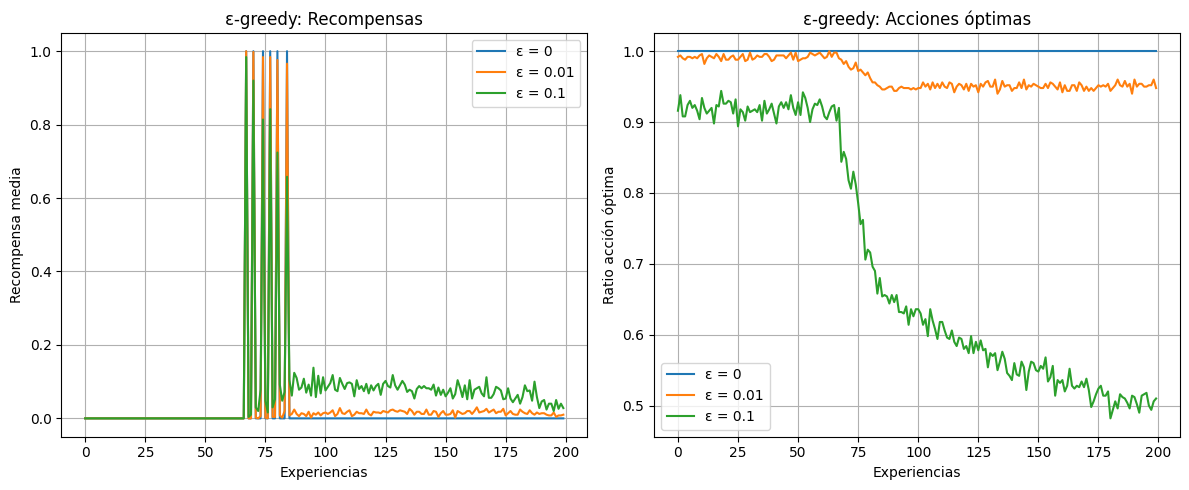

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, e in enumerate(epsilons):
    plt.plot(rewards_eps[i], label=f'ε = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('ε-greedy: Recompensas')

plt.subplot(1, 2, 2)
for i, e in enumerate(epsilons):
    plt.plot(optimal_eps[i], label=f'ε = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('ε-greedy: Acciones óptimas')

plt.tight_layout()
plt.show()

In [14]:
print("\n2. TÉCNICA VALORES INICIALES OPTIMISTAS")
rewards_opt, optimal_opt, eps_opt = run_optimistic_initialization_experiment(env)


2. TÉCNICA VALORES INICIALES OPTIMISTAS
=== Ejecutando experimento Valores Optimistas ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


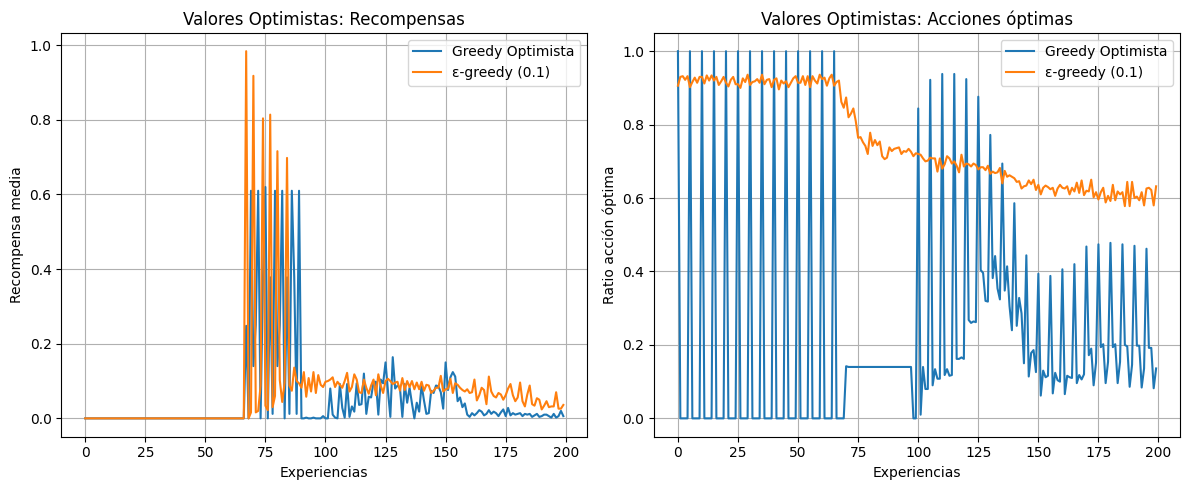

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels = ['Greedy Optimista', 'ε-greedy (0.1)']
for i, label in enumerate(labels):
    plt.plot(rewards_opt[i], label=label)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('Valores Optimistas: Recompensas')

plt.subplot(1, 2, 2)
for i, label in enumerate(labels):
    plt.plot(optimal_opt[i], label=label)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Valores Optimistas: Acciones óptimas')

plt.tight_layout()
plt.show()

In [16]:
print("\n3. TÉCNICA UCB (UPPER CONFIDENCE BOUND)")
rewards_ucb, optimal_ucb, methods_ucb = run_ucb_experiment(env)


3. TÉCNICA UCB (UPPER CONFIDENCE BOUND)
=== Ejecutando experimento UCB ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


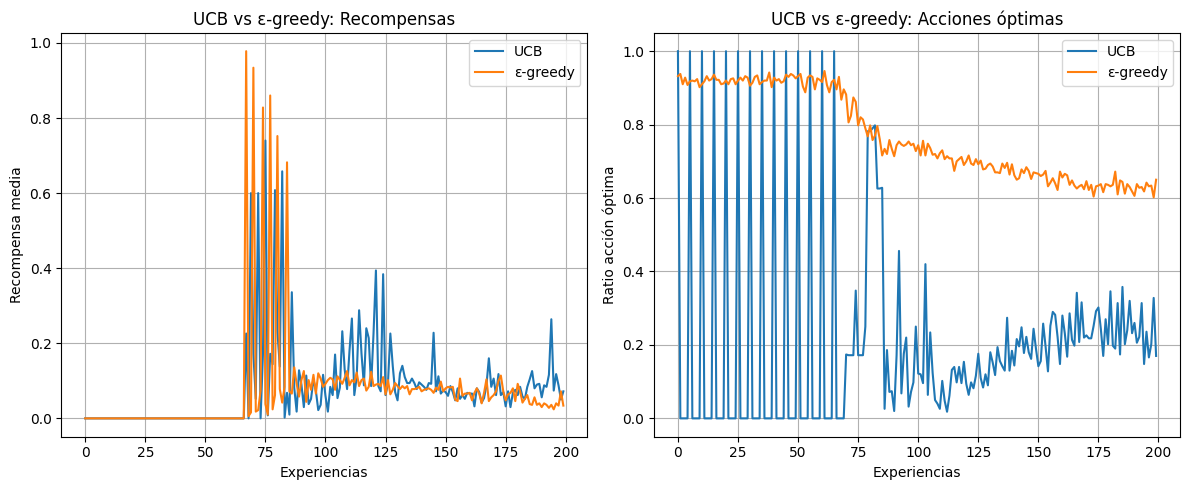

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, method in enumerate(methods_ucb):
    plt.plot(rewards_ucb[i], label=method)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('UCB vs ε-greedy: Recompensas')

plt.subplot(1, 2, 2)
for i, method in enumerate(methods_ucb):
    plt.plot(optimal_ucb[i], label=method)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('UCB vs ε-greedy: Acciones óptimas')

plt.tight_layout()
plt.show()

In [18]:
# Experimento 4: Algoritmos de Gradiente
print("\n4. TÉCNICA ALGORITMOS DE GRADIENTE")
rewards_grad, optimal_grad, alphas_grad = run_gradient_bandit_experiment(env)


4. TÉCNICA ALGORITMOS DE GRADIENTE
=== Ejecutando experimento Algoritmos de Gradiente ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


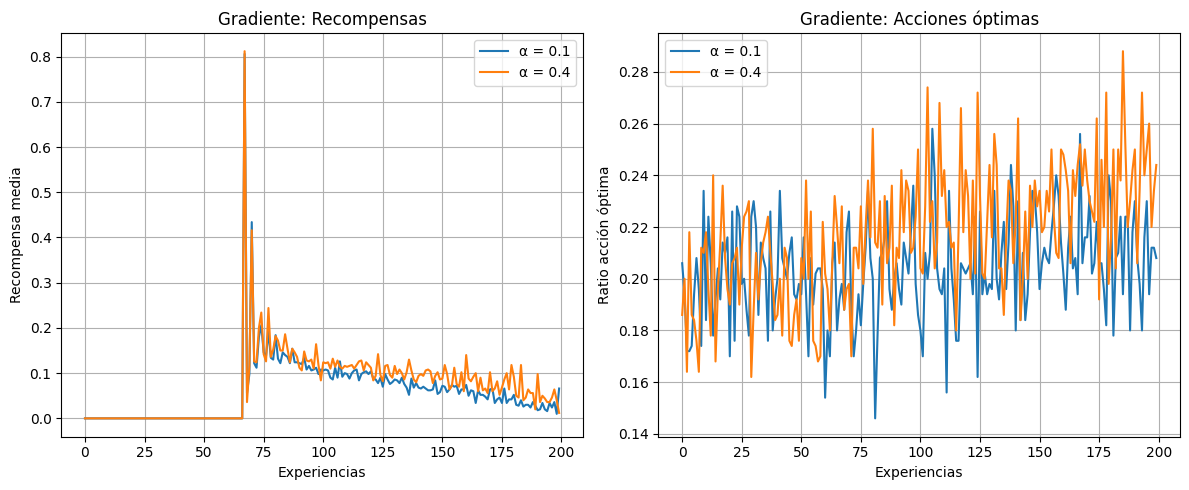

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, alpha in enumerate(alphas_grad):
    plt.plot(rewards_grad[i], label=f'α = {alpha}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('Gradiente: Recompensas')

plt.subplot(1, 2, 2)
for i, alpha in enumerate(alphas_grad):
    plt.plot(optimal_grad[i], label=f'α = {alpha}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Gradiente: Acciones óptimas')

plt.tight_layout()
plt.show()

In [20]:
env.close()

print("\n" + "=" * 50)
print("LABORATORIO COMPLETADO EXITOSAMENTE")
print("Se han ejecutado las 4 técnicas de bandits:")
print("- ε-greedy")
print("- Valores iniciales optimistas")
print("- UCB (Upper Confidence Bound)")
print("- Algoritmos de Gradiente")
print("=" * 50)


LABORATORIO COMPLETADO EXITOSAMENTE
Se han ejecutado las 4 técnicas de bandits:
- ε-greedy
- Valores iniciales optimistas
- UCB (Upper Confidence Bound)
- Algoritmos de Gradiente


🎮 LABORATORIO UCB CON Q-TABLE SIMPLIFICADA

=== Iniciando Experimento UCB ===
UCB Q-table inicializada:
  Acciones: 5
  Parámetro c: 2.0
  Tasa aprendizaje α: 0.1
Ms. Pac-Man con 5 acciones: ['No-op', 'Up', 'Right', 'Down', 'Left']
Episodio 20/100: Reward=13.950, Éxito=1.000
Episodio 40/100: Reward=14.800, Éxito=1.000
Episodio 60/100: Reward=12.700, Éxito=1.000
Episodio 80/100: Reward=11.250, Éxito=1.000
Episodio 100/100: Reward=12.500, Éxito=1.000

ANÁLISIS DE RESULTADOS UCB

📊 ESTADÍSTICAS GENERALES:
  Pasos totales: 20,000
  Recompensa total: 1304.00
  Recompensa promedio por paso: 0.0652
  Tasa de éxito general: 0.065

🎯 Q-VALUES APRENDIDOS:
  No-op   : Q= 0.0001, usado  3954 veces ( 19.8%)
  Up      : Q= 0.0060, usado  3995 veces ( 20.0%)
  Right   : Q= 0.0006, usado  3998 veces ( 20.0%)
  Down    : Q= 0.0011, usado  4039 veces ( 20.2%)
  Left    : Q= 0.0009, usado  4019 veces ( 20.1%)

🏆 MEJOR ACCIÓN: Up (Q=0.0060)

📈 RENDIMIENTO POR EPISODIOS:
  Recompensa promedio por episodio:

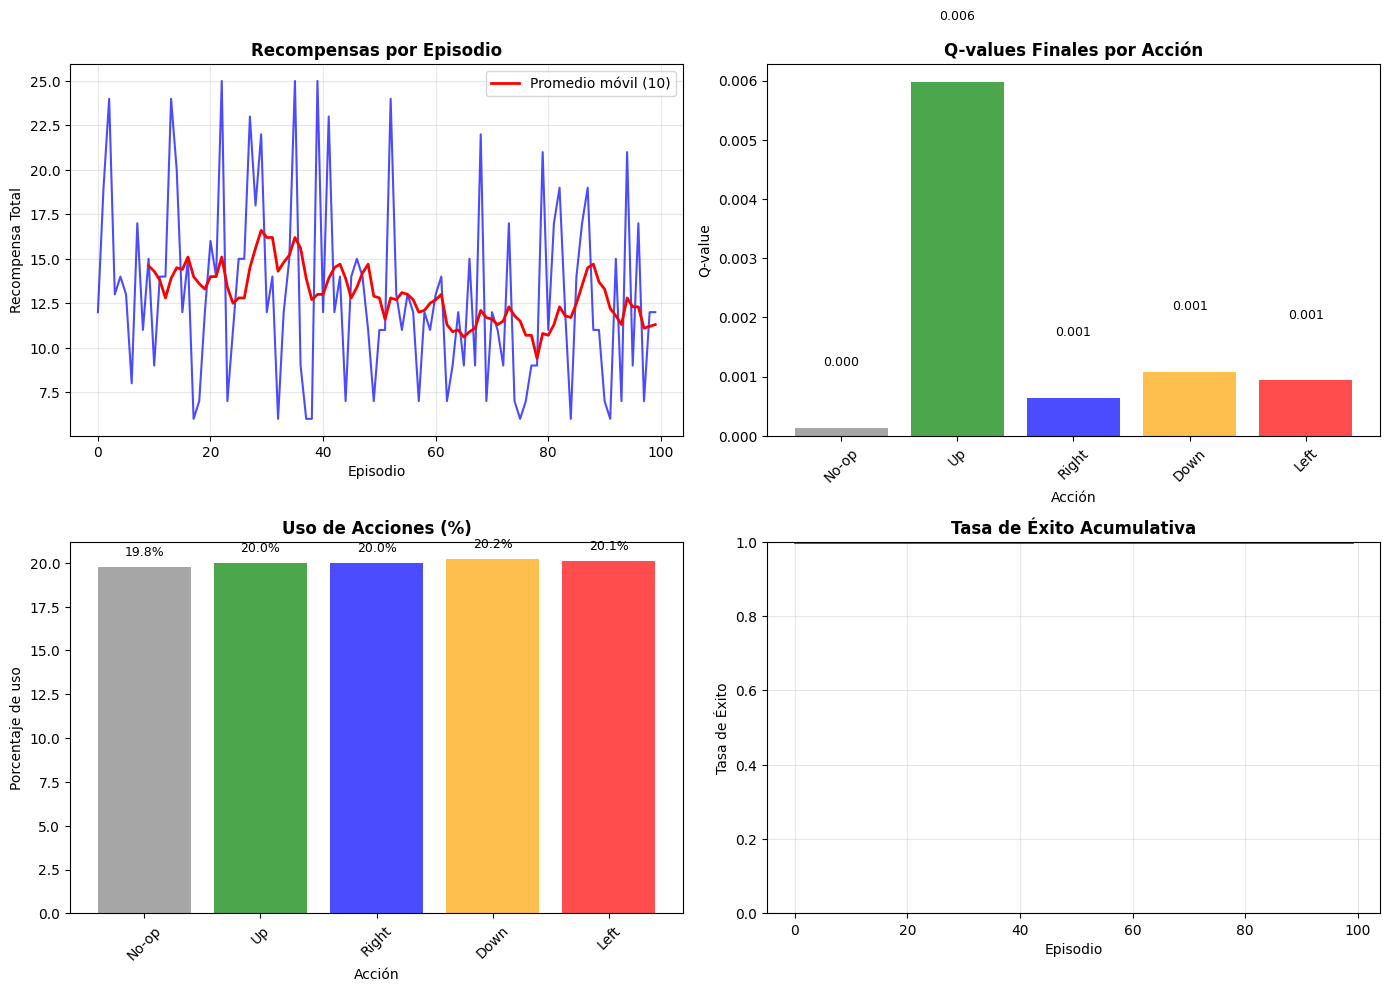


✅ EXPERIMENTO COMPLETADO
El agente UCB ha aprendido qué acciones son mejores en Ms. Pac-Man


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math

class SimpleUCB_QTable:
    def __init__(self, n_actions, c=2.0, alpha=0.1):
        """
        UCB simple con Q-table básica
        """
        self.n_actions = n_actions
        self.c = c  # Parámetro de confianza UCB
        self.alpha = alpha  # Tasa de aprendizaje

        # Q-table simple: solo valores Q por acción
        self.q_values = np.zeros(n_actions)

        # Contadores de visitas por acción
        self.action_counts = np.ones(n_actions)  # Evita división por 0

        # Contador total de pasos
        self.total_steps = 0

        # Historial de recompensas y acciones
        self.rewards_history = []
        self.actions_history = []

        print(f"UCB Q-table inicializada:")
        print(f"  Acciones: {n_actions}")
        print(f"  Parámetro c: {c}")
        print(f"  Tasa aprendizaje α: {alpha}")

    def select_action(self):
        """
        Selecciona acción usando UCB
        UCB(a) = Q(a) + c * sqrt(ln(t) / N(a))
        """
        self.total_steps += 1

        ucb_values = np.zeros(self.n_actions)

        for action in range(self.n_actions):
            # Valor Q (explotación)
            q_value = self.q_values[action]

            # Término de confianza (exploración)
            confidence = self.c * math.sqrt(math.log(self.total_steps) / self.action_counts[action])

            # UCB total
            ucb_values[action] = q_value + confidence

        # Seleccionar acción con mayor UCB
        action = np.argmax(ucb_values)

        return action, ucb_values

    def update_q_value(self, action, reward):
        """
        Actualiza Q-value de la acción con la recompensa recibida
        Q(a) ← Q(a) + α * (reward - Q(a))
        """
        # Actualizar contador
        self.action_counts[action] += 1

        # Actualizar Q-value
        old_q = self.q_values[action]
        self.q_values[action] = old_q + self.alpha * (reward - old_q)

        # Guardar historial
        self.rewards_history.append(reward)
        self.actions_history.append(action)

    def get_statistics(self):
        """Estadísticas del agente"""
        return {
            'total_steps': self.total_steps,
            'q_values': self.q_values.copy(),
            'action_counts': self.action_counts.copy(),
            'avg_reward': np.mean(self.rewards_history) if self.rewards_history else 0,
            'total_reward': np.sum(self.rewards_history),
            'success_rate': len([r for r in self.rewards_history if r > 0]) / len(self.rewards_history) if self.rewards_history else 0
        }

class MsPacManSimple:
    def __init__(self):
        """Entorno Ms. Pac-Man simplificado"""
        self.env = gym.make('ALE/MsPacman-v5', render_mode=None)
        self.actions = [0, 1, 2, 3, 4]  # No-op, Up, Right, Down, Left
        self.action_names = ['No-op', 'Up', 'Right', 'Down', 'Left']
        self.n_actions = len(self.actions)

        # Agente UCB
        self.agent = SimpleUCB_QTable(self.n_actions, c=2.0, alpha=0.1)

        print(f"Ms. Pac-Man con {self.n_actions} acciones: {self.action_names}")

def run_experiment(episodes=100, steps_per_episode=200):
    """Ejecuta el experimento UCB"""
    print("\n=== Iniciando Experimento UCB ===")

    # Crear entorno
    game = MsPacManSimple()
    agent = game.agent
    env = game.env

    episode_rewards = []
    episode_success = []

    for episode in range(episodes):
        # Reiniciar juego
        obs, info = env.reset()
        episode_reward = 0
        episode_positive_rewards = 0

        for step in range(steps_per_episode):
            # Seleccionar acción con UCB
            action_idx, ucb_values = agent.select_action()
            action = game.actions[action_idx]

            # Ejecutar acción
            next_obs, reward, terminated, truncated, info = env.step(action)

            # Normalizar recompensa
            normalized_reward = reward / 10.0

            # Actualizar Q-table
            agent.update_q_value(action_idx, normalized_reward)

            episode_reward += normalized_reward
            if normalized_reward > 0:
                episode_positive_rewards += 1

            if terminated or truncated:
                break

        episode_rewards.append(episode_reward)
        episode_success.append(episode_positive_rewards > 0)

        # Progreso cada 20 episodios
        if (episode + 1) % 20 == 0:
            recent_avg = np.mean(episode_rewards[-20:])
            recent_success = np.mean(episode_success[-20:])
            print(f"Episodio {episode + 1}/{episodes}: Reward={recent_avg:.3f}, Éxito={recent_success:.3f}")

    env.close()
    return episode_rewards, episode_success, agent

def analyze_results(episode_rewards, episode_success, agent):
    """Analiza y muestra resultados"""
    print("\n" + "="*50)
    print("ANÁLISIS DE RESULTADOS UCB")
    print("="*50)

    # Estadísticas del agente
    stats = agent.get_statistics()

    print(f"\n📊 ESTADÍSTICAS GENERALES:")
    print(f"  Pasos totales: {stats['total_steps']:,}")
    print(f"  Recompensa total: {stats['total_reward']:.2f}")
    print(f"  Recompensa promedio por paso: {stats['avg_reward']:.4f}")
    print(f"  Tasa de éxito general: {stats['success_rate']:.3f}")

    print(f"\n🎯 Q-VALUES APRENDIDOS:")
    action_names = ['No-op', 'Up', 'Right', 'Down', 'Left']
    for i, (q_val, count, name) in enumerate(zip(stats['q_values'], stats['action_counts'], action_names)):
        percentage = (count / stats['total_steps']) * 100
        print(f"  {name:8}: Q={q_val:7.4f}, usado {count:5.0f} veces ({percentage:5.1f}%)")

    # Mejor acción
    best_action = np.argmax(stats['q_values'])
    print(f"\n🏆 MEJOR ACCIÓN: {action_names[best_action]} (Q={stats['q_values'][best_action]:.4f})")

    # Estadísticas por episodios
    print(f"\n📈 RENDIMIENTO POR EPISODIOS:")
    print(f"  Recompensa promedio por episodio: {np.mean(episode_rewards):.3f}")
    print(f"  Mejor episodio: {np.max(episode_rewards):.3f}")
    print(f"  Peor episodio: {np.min(episode_rewards):.3f}")
    print(f"  Episodios exitosos: {sum(episode_success)}/{len(episode_success)} ({np.mean(episode_success):.3f})")

    # Mejora en el tiempo
    first_half = episode_rewards[:len(episode_rewards)//2]
    second_half = episode_rewards[len(episode_rewards)//2:]
    improvement = np.mean(second_half) - np.mean(first_half)
    print(f"  Mejora (2da mitad vs 1ra): {improvement:+.4f}")

def plot_results(episode_rewards, episode_success, agent):
    """Visualiza los resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Recompensas por episodio
    axes[0, 0].plot(episode_rewards, alpha=0.7, color='blue')
    axes[0, 0].set_title('Recompensas por Episodio', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Recompensa Total')
    axes[0, 0].grid(True, alpha=0.3)

    # Promedio móvil
    window = min(10, len(episode_rewards)//5)
    if window > 1:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(episode_rewards)), moving_avg,
                       color='red', linewidth=2, label=f'Promedio móvil ({window})')
        axes[0, 0].legend()

    # 2. Q-values finales
    stats = agent.get_statistics()
    action_names = ['No-op', 'Up', 'Right', 'Down', 'Left']
    colors = ['gray', 'green', 'blue', 'orange', 'red']

    bars = axes[0, 1].bar(action_names, stats['q_values'], color=colors, alpha=0.7)
    axes[0, 1].set_title('Q-values Finales por Acción', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Acción')
    axes[0, 1].set_ylabel('Q-value')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Agregar valores en las barras
    for bar, q_val in zip(bars, stats['q_values']):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{q_val:.3f}', ha='center', va='bottom', fontsize=9)

    # 3. Distribución de uso de acciones
    usage_percentages = (stats['action_counts'] / stats['total_steps']) * 100
    bars = axes[1, 0].bar(action_names, usage_percentages, color=colors, alpha=0.7)
    axes[1, 0].set_title('Uso de Acciones (%)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Acción')
    axes[1, 0].set_ylabel('Porcentaje de uso')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Agregar porcentajes en las barras
    for bar, pct in zip(bars, usage_percentages):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

    # 4. Tasa de éxito acumulativa
    success_cumulative = np.cumsum(episode_success) / np.arange(1, len(episode_success) + 1)
    axes[1, 1].plot(success_cumulative, color='green', linewidth=2)
    axes[1, 1].set_title('Tasa de Éxito Acumulativa', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Episodio')
    axes[1, 1].set_ylabel('Tasa de Éxito')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# EJECUCIÓN DEL EXPERIMENTO
if __name__ == "__main__":
    print("🎮 LABORATORIO UCB CON Q-TABLE SIMPLIFICADA")
    print("="*55)

    # Ejecutar experimento
    episode_rewards, episode_success, agent = run_experiment(episodes=100, steps_per_episode=200)

    # Analizar resultados
    analyze_results(episode_rewards, episode_success, agent)

    # Mostrar gráficos
    plot_results(episode_rewards, episode_success, agent)

    print("\n✅ EXPERIMENTO COMPLETADO")
    print("El agente UCB ha aprendido qué acciones son mejores en Ms. Pac-Man")